In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
import pandas as pd
train_path = '/content/gdrive/MyDrive/eda/twitter_training.csv'
val_path = '/content/gdrive/MyDrive/eda/twitter_validation.csv'
train_df = pd.read_csv(train_path, header=None, names=[ 'Entity', 'Sentiment', 'Text'])
val_df = pd.read_csv(val_path, header=None, names=[ 'Entity', 'Sentiment', 'Text'])

df = pd.concat([train_df, val_df], ignore_index=True)
print(df.head())

        Entity Sentiment                                               Text
0  Borderlands  Positive  im getting on borderlands and i will murder yo...
1  Borderlands  Positive  I am coming to the borders and I will kill you...
2  Borderlands  Positive  im getting on borderlands and i will kill you ...
3  Borderlands  Positive  im coming on borderlands and i will murder you...
4  Borderlands  Positive  im getting on borderlands 2 and i will murder ...


In [20]:
df.info()
train_df.info()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Entity     75682 non-null  object
 1   Sentiment  75682 non-null  object
 2   Text       74996 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 74682 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Entity     74682 non-null  object
 1   Sentiment  74682 non-null  object
 2   Text       73996 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3364 to 6960
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Entity     1000 non-null   object
 1   Sentiment  1000 non-null   object
 2   Text       1000 non-null   object
dtypes: object(3)


In [21]:

train_df.dropna()
val_df.dropna()
print(train_df.shape)
print(val_df.shape)

(74682, 3)
(1000, 3)


In [23]:
import re
import numpy as np
import string
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
def clean_text(text):
    # Convert to string and handle NaN
    text = str(text) if pd.notna(text) else ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags (keep hashtag text for context, per paper)
    text = re.sub(r'@[\w]+', '', text)
    text = re.sub(r'#', '', text)

    # Remove punctuation (except ! ? for sentiment)
    text = text.translate(str.maketrans('', '', string.punctuation.replace('!', '').replace('?', '')))

    # Convert to lowercase
    text = text.lower()

    # Replace emojis with their meanings
    text = emoji.demojize(text)

    return text

In [24]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#extendable
slang_dict = {
    'lmao': 'laughing my ass off',
    'wtf': 'what the fuck',
    'gr8': 'great',
    'af': 'as fuck',
    'u': 'you',
    'tho': 'though',
    'brb': 'be right back',
    'lol': 'laughing out loud',
    'idk': 'i dont know',
    'imma': 'i am going to',
    'gonna': 'going to',
    'b4': 'before'
}
def process_slang_and_stopwords(text):

    words = text.split()
    words = [slang_dict.get(word, word) for word in words]
    words = [word for word in words if word not in stop_words or word in ['not', 'no']]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
train_df['Processed_Text']=train_df['Text'].apply(clean_text)
train_df['Processed_Text']=train_df['Processed_Text'].apply(process_slang_and_stopwords)
val_df['Processed_Text']=val_df['Text'].apply(clean_text)
val_df['Processed_Text']=val_df['Processed_Text'].apply(process_slang_and_stopwords)

plot train dataset


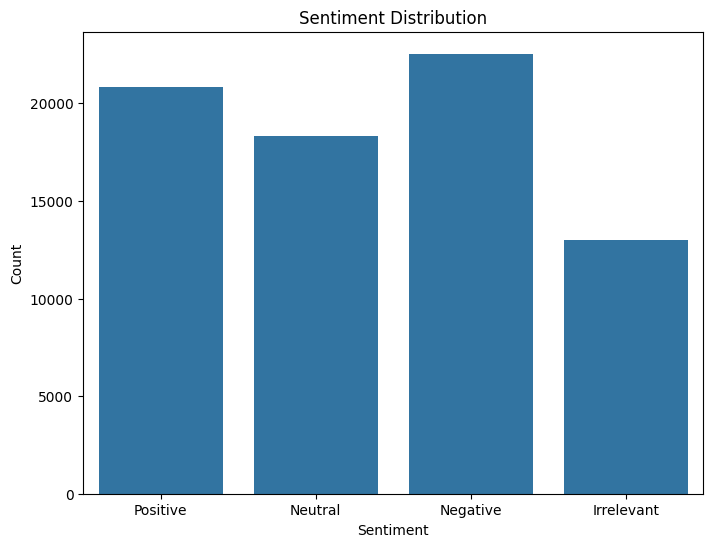

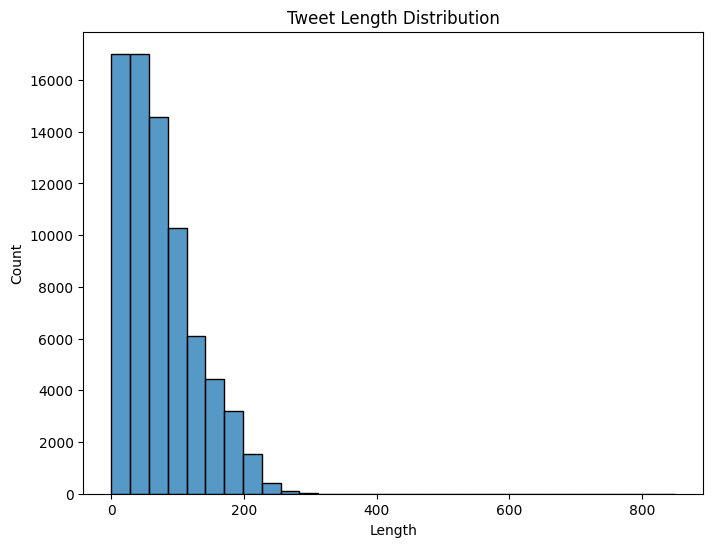

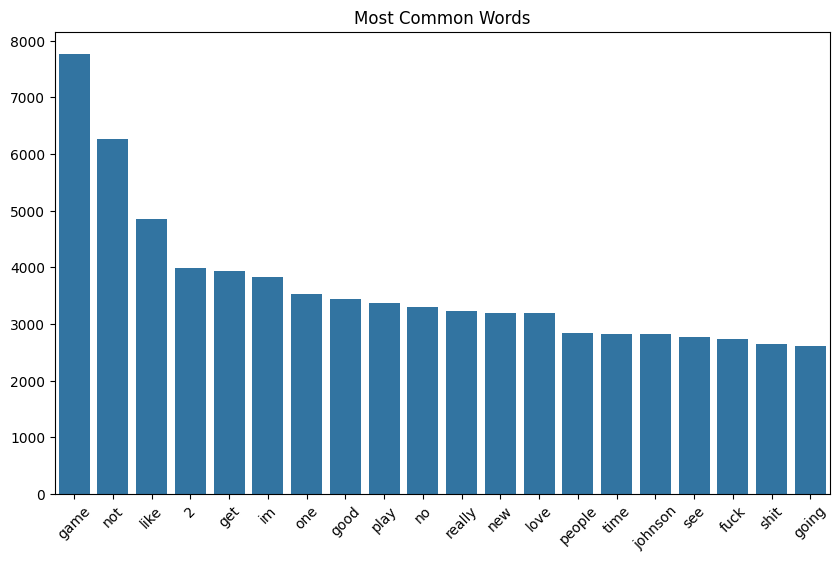

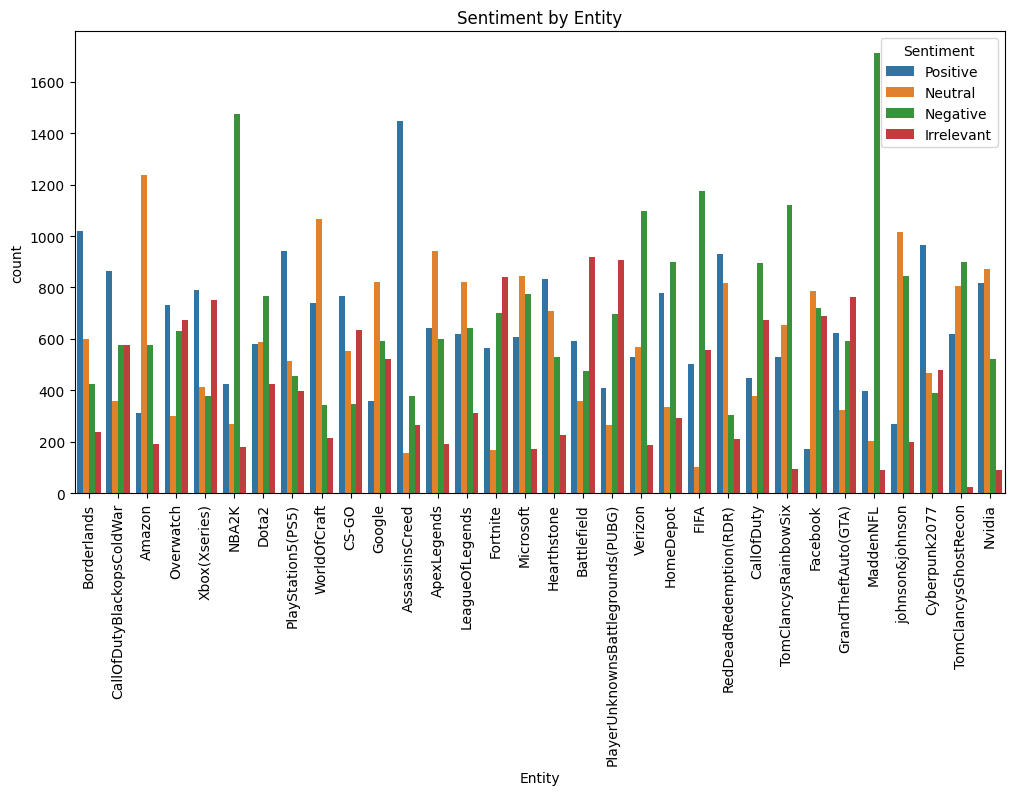

In [26]:
print('plot train dataset')
print('='*30)
# Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.close()

# Tweet Length Analysis
train_df['Text_Length'] = train_df['Processed_Text'].str.len()
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='Text_Length', bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()
plt.close()

# Most Common Words
all_words = ' '.join(train_df['Processed_Text']).split()
common_words = Counter(all_words).most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()
plt.close()

# Sentiment per Entity
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Entity', hue='Sentiment')
plt.title('Sentiment by Entity')
plt.xticks(rotation=90)
plt.show()
plt.close()


plot train dataset


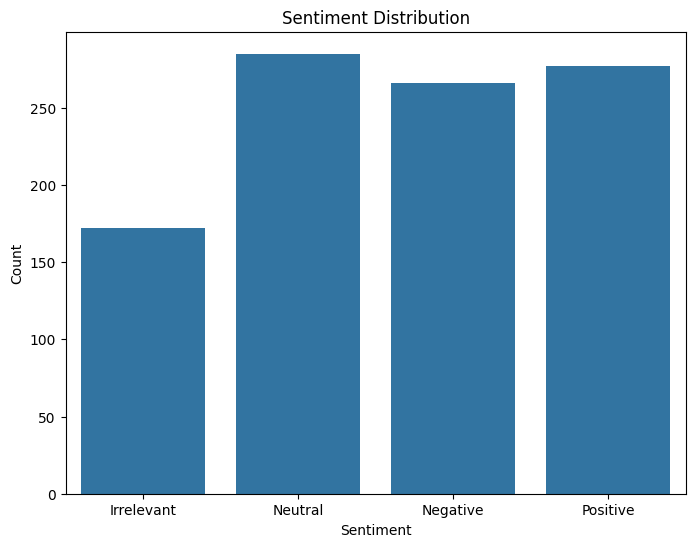

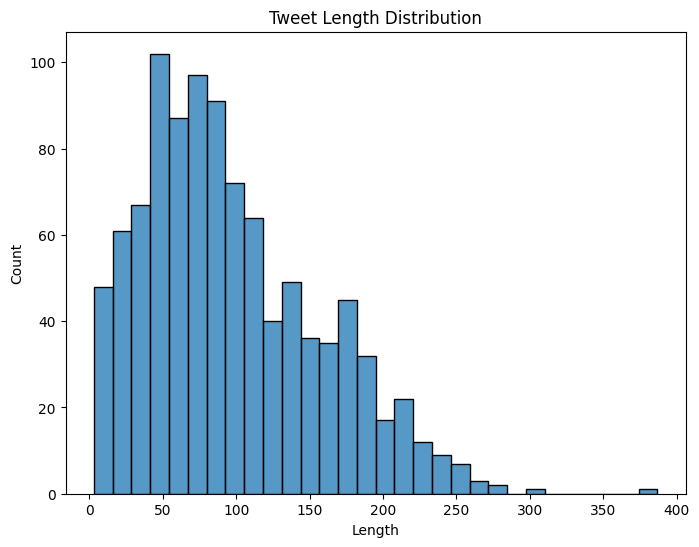

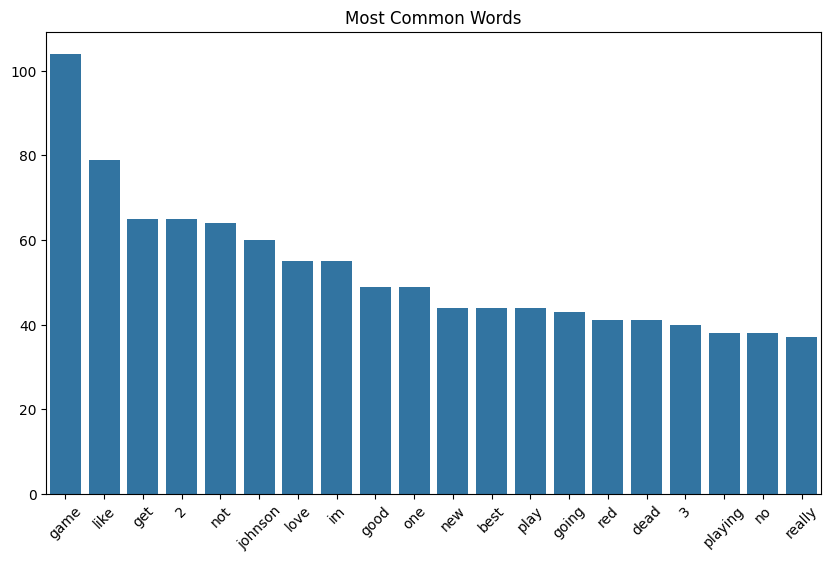

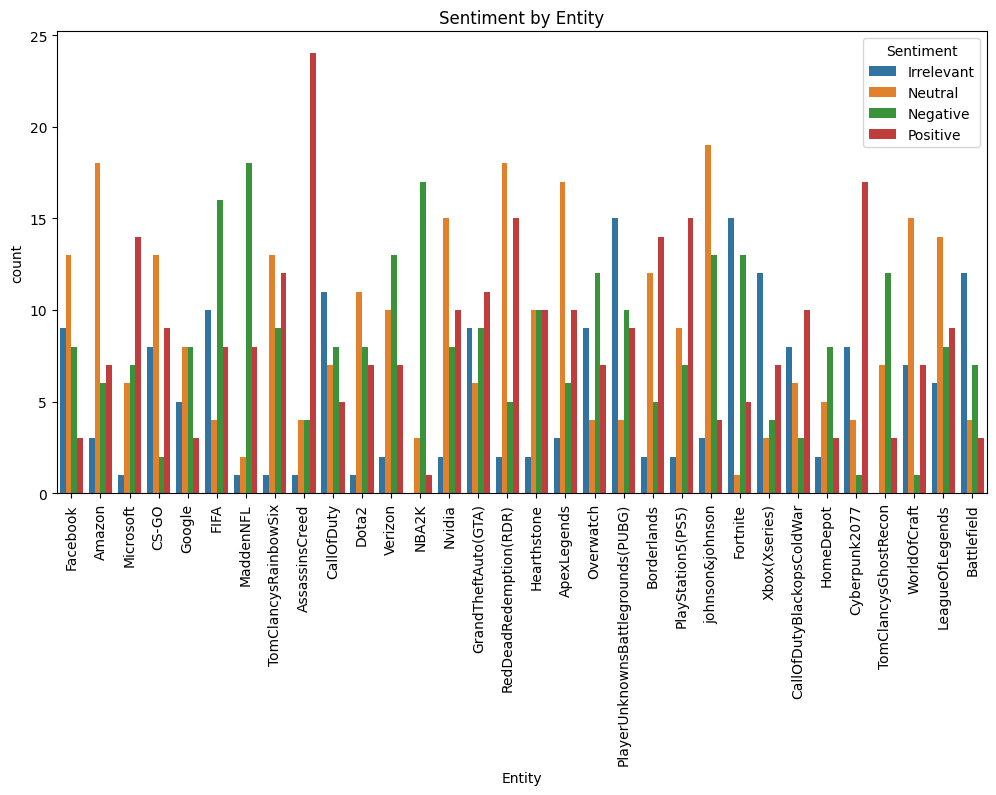

In [27]:
print('plot train dataset')
print('='*30)
# Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=val_df, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.close()

# Tweet Length Analysis
val_df['Text_Length'] = val_df['Processed_Text'].str.len()
plt.figure(figsize=(8, 6))
sns.histplot(data=val_df, x='Text_Length', bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()
plt.close()

# Most Common Words
all_words = ' '.join(val_df['Processed_Text']).split()
common_words = Counter(all_words).most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()
plt.close()

# Sentiment per Entity
plt.figure(figsize=(12, 6))
sns.countplot(data=val_df, x='Entity', hue='Sentiment')
plt.title('Sentiment by Entity')
plt.xticks(rotation=90)
plt.show()
plt.close()


In [28]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=300):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = 0 if self.labels[idx] == 'Negative' else 1 if self.labels[idx] == 'Positive' else 2 if self.labels[idx] == 'Neutral' else 3  # Irrelevant as 3
        encoding = self.tokenizer(text, add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [32]:
train_texts = train_df['Processed_Text'].values
val_texts = val_df['Processed_Text'].values
train_labels = train_df['Sentiment'].values
val_labels = val_df['Sentiment'].values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train_df.to_csv('/content/gdrive/My Drive/eda/processed_twitter_train.csv', index=False)
val_df.to_csv('/content/gdrive/My Drive/eda/processed_twitter_val.csv', index=False)